1593
样本数: 1593 像素数: 256


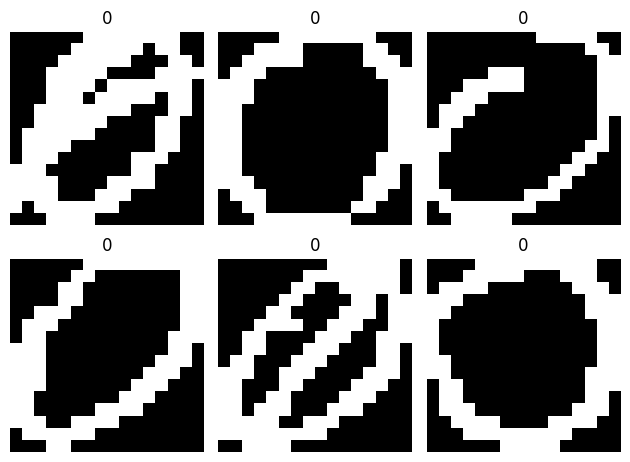

In [1]:
import numpy as np
import matplotlib.pyplot as plt #注意依赖库的安装

raw = np.loadtxt('semeion.data')
X, y = raw[:, :256], raw[:, 256:]
y = np.argmax(y, axis=1)          # 独热 → 0~9 整数
print(len(y))
print('样本数:', len(X), '像素数:', X.shape[1])

# 随机画 6 张图
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].reshape(16,16), cmap='gray')
    plt.title(y[i]); plt.axis('off')
plt.tight_layout(); plt.show()

可以看到是**黑白**的**全屏数字**

In [2]:
#我想要将X和y划分为训练集和测试集
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=41)

In [3]:
print("训练集样本数:", len(X_train), "测试集样本数:", len(X_test))

训练集样本数: 1274 测试集样本数: 319


In [4]:
#我将使用KNN，对测试集进行预测，使用欧式距离，k使用从3-15的所有数字，如果投票的最终结果是平局，则随机选择最大值中的一个
#我将手写KNN算法，不使用包
def euclid_distance(a,b):
    return np.sqrt(np.sum((a-b)**2))
def KNN_Classifier(X_train,y_train,X_test,k):
    y_pred = []
    for x in X_test:
        distances = []
        for i in range(len(X_train)):
            dist = euclid_distance(x,X_train[i])
            distances.append((dist,y_train[i]))
        distances.sort(key = lambda x:x[0],reverse=False)
        neighbors = distances[:k]
        votes = {}
        for neighbor in neighbors:
            label = neighbor[1]
            if label in votes:
                votes[label] += 1
            else:
                votes[label] = 1
        sorted_voted = sorted(votes.items(),key=lambda x:x[1],reverse=True)
        max_num_votes = sorted_voted[0][1]
        candidates = [sorted_voted[i][0] for i in range(len(sorted_voted)) if sorted_voted[i][1] == max_num_votes]
        y_pred.append(np.random.choice(candidates))
    return y_pred
def accuracy(y_true,y_pred):
    return np.sum(y_true == y_pred) / len(y_true)


    

k = 1 时，KNeighborsClassifier准确率为：0.9248，KNN_Classifier准确率为：0.9248
k = 2 时，KNeighborsClassifier准确率为：0.8621，KNN_Classifier准确率为：0.8997
k = 3 时，KNeighborsClassifier准确率为：0.8966，KNN_Classifier准确率为：0.9060
k = 4 时，KNeighborsClassifier准确率为：0.8966，KNN_Classifier准确率为：0.9122
k = 5 时，KNeighborsClassifier准确率为：0.9091，KNN_Classifier准确率为：0.9185
k = 6 时，KNeighborsClassifier准确率为：0.8934，KNN_Classifier准确率为：0.9091
k = 7 时，KNeighborsClassifier准确率为：0.9028，KNN_Classifier准确率为：0.9122
k = 8 时，KNeighborsClassifier准确率为：0.9060，KNN_Classifier准确率为：0.9060
k = 9 时，KNeighborsClassifier准确率为：0.9060，KNN_Classifier准确率为：0.9060
k = 10 时，KNeighborsClassifier准确率为：0.9060，KNN_Classifier准确率为：0.9091
k = 11 时，KNeighborsClassifier准确率为：0.9060，KNN_Classifier准确率为：0.9122
k = 12 时，KNeighborsClassifier准确率为：0.9060，KNN_Classifier准确率为：0.9028
k = 13 时，KNeighborsClassifier准确率为：0.9122，KNN_Classifier准确率为：0.9122
k = 14 时，KNeighborsClassifier准确率为：0.9060，KNN_Classifier准确率为：0.9060
k = 15 时，KNeighborsClassifier准确率为：0.9091，KNN_Classifier准确率为：0.9122


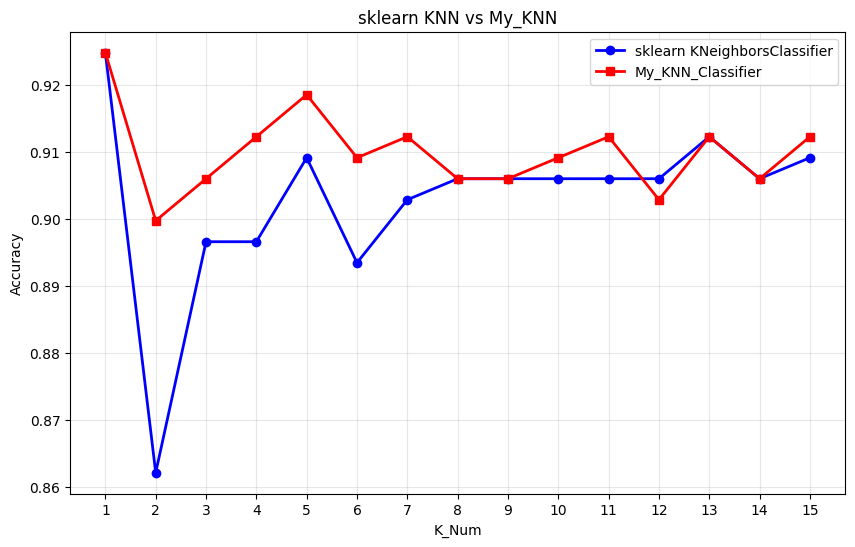

In [5]:
from sklearn.neighbors import KNeighborsClassifier
#接下来我对不同的K值进行测试，对比sklearn的KNeighborsClassifier和自己实现的KNN_Classifier
k_values = []
acc_values_1 = []  # sklearn的KNeighborsClassifier准确率
acc_values_2 = []  # 自己实现的KNN_Classifier准确率

for k in range(1,16):
    # 使用sklearn的KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred_1 = knn.predict(X_test)
    
    # 使用自己实现的KNN_Classifier
    y_pred_2 = KNN_Classifier(X_train,y_train,X_test,k)
    
    # 计算准确率
    acc_1 = accuracy(y_test,y_pred_1) #sklearn版本的精准度
    acc_2 = accuracy(y_test,y_pred_2) #自实现版本的精准度
    
    # 保存结果
    k_values.append(k)
    acc_values_1.append(acc_1)
    acc_values_2.append(acc_2)
    
    print(f"k = {k} 时，KNeighborsClassifier准确率为：{acc_1:.4f}，KNN_Classifier准确率为：{acc_2:.4f}")

#画出在不同实现方式下k值和准确率的关系图
plt.figure(figsize=(10, 6))
plt.plot(k_values, acc_values_1, 'b-o', label='sklearn KNeighborsClassifier', linewidth=2, markersize=6)
plt.plot(k_values, acc_values_2, 'r-s', label='My_KNN_Classifier', linewidth=2, markersize=6)
plt.xlabel('K_Num')
plt.ylabel('Accuracy')
plt.title('sklearn KNN vs My_KNN')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(k_values)
plt.show()


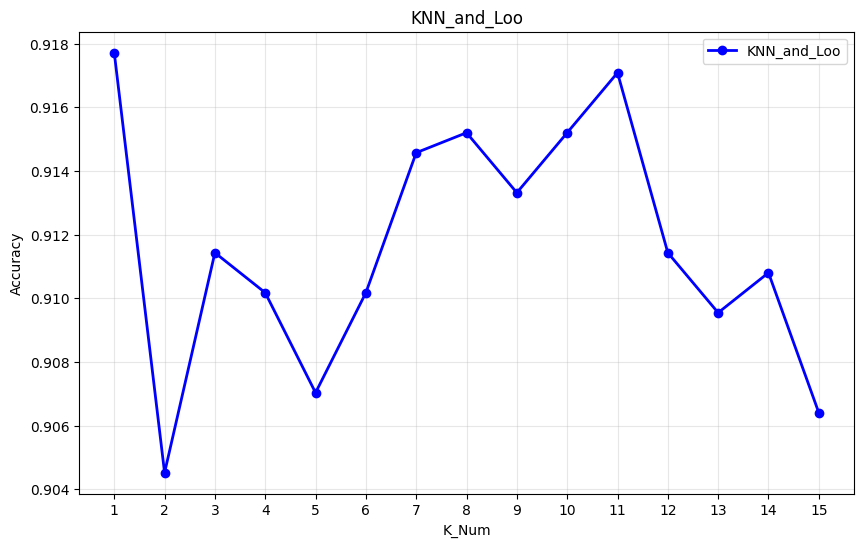

In [6]:
#接下来我将使用KNN和LOO结合增加准确率,输出的是准确率
def KNN_and_Loo(X,y,k):
#先按照顺序选择一个样本作为测试集，其他样本作为训练集
    num = 0;
    for i in range(len(X)):
        X_train = np.concatenate((X[:i],X[i+1:]))
        y_train = np.concatenate((y[:i],y[i+1:]))
        X_test  = X[i]
        y_test  = y[i]
        result  = KNN_Classifier(X_train,y_train,[X_test] ,k)
        if result[0] == y_test:
            num += 1   
    return num / (len(X)-1)


from joblib import Parallel, delayed
#使用多线程加速计算
def loo_iterate(i,X,y,k):
   
    X_train = np.concatenate((X[:i],X[i+1:]))
    y_train = np.concatenate((y[:i],y[i+1:]))
    X_test  = X[i]
    y_test  = y[i]
    result  = KNN_Classifier(X_train,y_train,[X_test] ,k)
    return 1 if result[0] == y_test else 0

def KNN_and_Loo_parallel(X,y,k,n_jobs = -1):
    results = Parallel(n_jobs = n_jobs)(delayed(loo_iterate)(i,X,y,k) for i in range(len(X)-1))
    return np.sum(results) / (len(X)-1)

#接下来计算不同k值（1-16）下的准确率
k_values =range(1,16)
acc_values = []

for k in k_values:
    acc = KNN_and_Loo_parallel(X,y,k)
    acc_values.append(acc)

#接下来画出acc在不同的k值下的图
plt.figure(figsize=(10, 6))
plt.plot(k_values, acc_values, 'b-o', label='KNN_and_Loo', linewidth=2, markersize=6)
plt.xlabel('K_Num')
plt.ylabel('Accuracy')
plt.title('KNN_and_Loo')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(k_values)
plt.show()


